<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
categories = ['NORMAL','PNEUMONIA']
img_size = 128 

def get_images(dir): 
    images_array = []
    for category in categories: 
        path = os.path.join(dir, category)
        label = categories.index(category)
        for image in tqdm(os.listdir(path)): 
            try:
                img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE) #rgb to greyscale 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # set image size 
                images_array.append([resized_arr, label])
            except Exception as e:
                print(e)
    return np.array(images_array)

train_dir = '/content/drive/MyDrive/Pneumonia/train'
val_dir = '/content/drive/MyDrive/Pneumonia/val'
test_dir = '/content/drive/MyDrive/Pneumonia/test'

train = get_images(train_dir)
val = get_images(val_dir)
test = get_images(test_dir)

100%|██████████| 3933/3933 [00:38<00:00, 101.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
100%|██████████| 390/390 [00:03<00:00, 103.62it/s]


In [ ]:
def format_img(data): #resize data for deep learning
  x = []
  y = []
  for feature, label in data: 
    x.append(np.array(feature).reshape(img_size,img_size,1))
    y.append(np.array(label))
  return np.array(x), np.array(y)

x_train, y_train = format_img(train)
x_val, y_val = format_img(val)
x_test, y_test = format_img(test)

In [ ]:
epoch_size = 15
batch_size = 32 

train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = train_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=len(x_test))

In [ ]:
#@title 
x_train, y_train, x_val, y_val, x_test, y_test = [], [], [], [], [], []

for pixels, label in train:
    x_train.append(pixels)
    y_train.append(label)

for pixels, label in test:
    x_test.append(pixels)
    y_test.append(label)
    
for pixels, label in val:
    x_val.append(pixels)
    y_val.append(label)

# resize data for neural network training
x_train = np.array(x_train).reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = np.array(x_val).reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

class:  NORMAL


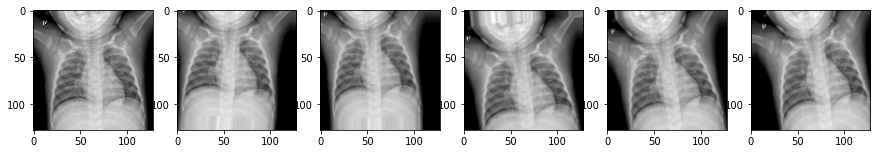

In [ ]:
#@title augmented image sample
#augmented images of a sample image 
fig, axes = plt.subplots(1,6,figsize=(15,15))
orig_img = np.array([x_train[0]]) #first image in the training set (original: non-augmented)
axes[0].imshow(orig_img[0].reshape(img_size,img_size), cmap='gray') 
for i in range(5): #display five generated augmented images
  sample, label = train_datagen.flow(orig_img, y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')
print("class: ", categories[label[0]])

In [ ]:
#@title create_plot
def create_plot(history, epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(12,6)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

##balancedDataGenerator

In [ ]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size= batch_size):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(x_train, y_train, train_datagen, batch_size=32) 
steps_per_epoch = balanced_gen.steps_per_epoch #generated_image, label = train.__getitem__(18)
y_gen = [balanced_gen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True)) #number of each label changes every training *

(array([0, 1]), array([3919, 3921]))


#CNN Modeling

In [ ]:
#model 
def create_model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    return model
# model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

Epoch 1/15
166/166 [==============================] - 10s 57ms/step - loss: 0.3524 - accuracy: 0.8851 - val_loss: 12.9553 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
166/166 [==============================] - 9s 55ms/step - loss: 0.1455 - accuracy: 0.9431 - val_loss: 9.8600 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
166/166 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9439
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 9s 55ms/step - loss: 0.1474 - accuracy: 0.9439 - val_loss: 11.4078 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
166/166 [==============================] - 9s 55ms/step - loss: 0.1064 - accuracy: 0.9645 - val_loss: 2.6450 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/15
166/166 [==============================] - 9s 56ms/step - loss: 0.0985 - accuracy: 0.9667 - val_loss: 0.9304 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/15
166/166 [============================

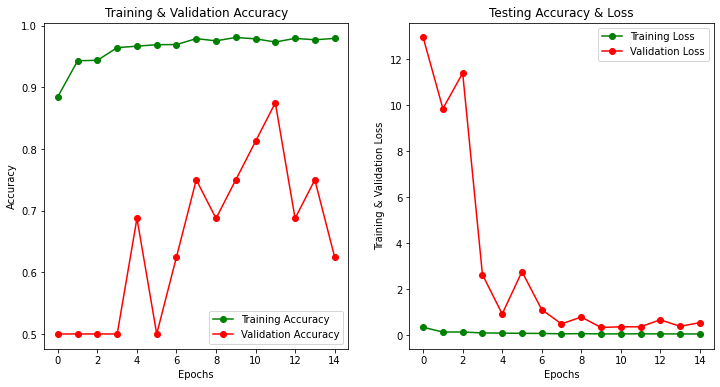

In [ ]:
#with augmentation
model = create_model()
history = model.fit(train_generator, epochs=epoch_size, validation_data=val_generator, callbacks = [learning_rate_reduction])
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

Epoch 1/15
245/245 [==============================] - 15s 58ms/step - loss: 0.3073 - accuracy: 0.9041 - val_loss: 9.0521 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
245/245 [==============================] - 15s 58ms/step - loss: 0.1482 - accuracy: 0.9468 - val_loss: 9.7561 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
245/245 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9502
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
245/245 [==============================] - 14s 57ms/step - loss: 0.1287 - accuracy: 0.9502 - val_loss: 1.3591 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
245/245 [==============================] - 14s 56ms/step - loss: 0.0919 - accuracy: 0.9695 - val_loss: 0.1954 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 5/15
245/245 [==============================] - 14s 59ms/step - loss: 0.0784 - accuracy: 0.9736 - val_loss: 1.7143 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/15
245/245 [==========================

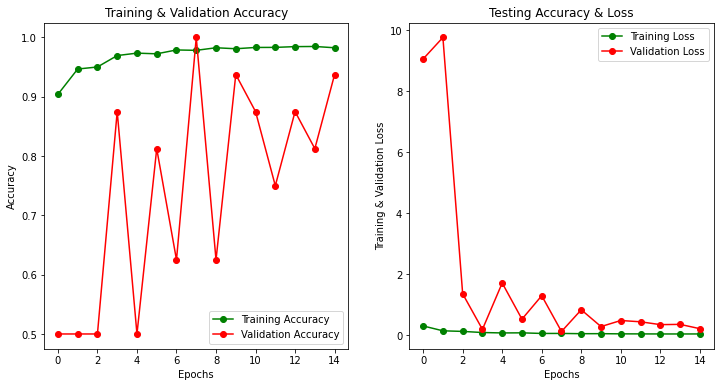

In [ ]:
#balanced augmentation
model = create_model()
history = model.fit(balanced_gen, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction])
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)

Epoch 1/15
166/166 [==============================] - 10s 56ms/step - loss: 0.2614 - accuracy: 0.9033 - val_loss: 7.5417 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
166/166 [==============================] - 9s 54ms/step - loss: 0.1549 - accuracy: 0.9456 - val_loss: 12.3224 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
166/166 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9503
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 9s 54ms/step - loss: 0.1295 - accuracy: 0.9503 - val_loss: 9.0556 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
166/166 [==============================] - 9s 55ms/step - loss: 0.1006 - accuracy: 0.9622 - val_loss: 0.5342 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 5/15
166/166 [==============================] - 9s 55ms/step - loss: 0.0954 - accuracy: 0.9666 - val_loss: 0.6292 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/15
165/166 [============================>

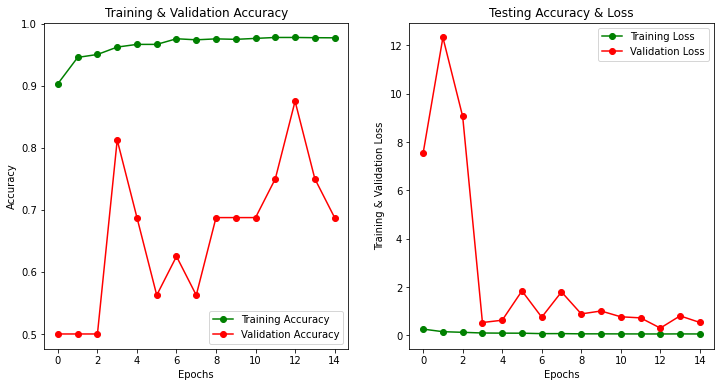

In [ ]:
#without augmentation
model = create_model()
history = model.fit(train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction])
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(history, epoch_size)